# How to get exposure data from OpenStreetMap


## Introduction
[OpenStreetMap data](https://www.openstreetmap.org/) is a freely-accessible and valuable data source which can provide information on the geolocations of a variety of assets such as critical infrastructures, buildings, or ecosystems. Such data can then be used within the risk modelling chain of CLIMADA as exposures. In this tutorial we first show how to retrieve exposure data by querying the [OpenStreetMap database](https://www.openstreetmap.org/) using the [osm-flex](https://osm-flex.readthedocs.io/en/latest/?badge=latest) module. In a second time, we provide a brief example of an impact calculation within CLIMADA using the retrieved OSM data as exposures. 

## Quick example
Here we provide a quick example of an impact calculation with CLIMADA and OSM data.
We use in this example main roads in the Netherlands as exposures, and winter storms
as hazard. We load the osm data using `osm-flex` and disaggregate the exposures, 
compute the damages, and reaggregate the exposures to their original shape using the 
function `calc_geom_impact` from the util module `lines_polys_handler`.

In [ ]:
import matplotlib.pyplot as plt
import osm_flex
import osm_flex.download
import osm_flex.extract
import osm_flex.clip
import osm_flex.simplify

from climada import CONFIG

osm_flex.enable_logs()

import warnings

warnings.filterwarnings("ignore")

import logging
from climada.util.config import LOGGER

LOGGER.setLevel(logging.ERROR)

The first step is to download a raw osm.pbf file ("data dump") for Netherlands from geofabrik.de 
and extract the layer of interest (here roads), but other layers can be calculated (see CLIMADA and OpenStreetMap [section](#climada-and-openstreetmap))

In [ ]:
# (checks if file honduras-latest.osm.pbf already exists)
# file is stored as defined in osm_flex.config.OSM_DATA_DIR unless specified otherwise
iso3 = "NLD"
path_ctr_dump = osm_flex.download.get_country_geofabrik(iso3)

# lets extract all roads from the Honduras file, via the wrapper
gdf_roads = osm_flex.extract.extract_cis(path_ctr_dump, "road")

# set crs
gdf_roads = gdf_roads.to_crs(epsg=4326)

INFO:osm_flex.download:Skip existing file: /Users/lseverino/osm/osm_bpf/netherlands-latest.osm.pbf
INFO:osm_flex.extract:query is finished, lets start the loop
extract points: 0it [00:19, ?it/s]
INFO:osm_flex.extract:query is finished, lets start the loop
extract multipolygons: 100%|██████████| 6/6 [01:32<00:00, 15.48s/it]
INFO:osm_flex.extract:query is finished, lets start the loop
extract lines: 100%|██████████| 861875/861875 [00:48<00:00, 17801.67it/s]


Next, we set up the exposure, and select our hazard and vulnerability.

In [104]:
from climada.util.api_client import Client
from climada.hazard import TropCyclone
import climada.util.lines_polys_handler as u_lp
from climada.entity.impact_funcs import ImpactFuncSet
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope

from climada.entity import Exposures


HAZ = Client().get_hazard("storm_europe", name="test_haz_WS_nl", status="test_dataset")

EXP_LINE = Exposures(gdf_roads)

IMPF_LINE = ImpfStormEurope.from_welker()

IMPF_SET = ImpactFuncSet([IMPF_LINE])

EXP_LINE.data["impf_WS"] = 1  # specify impact function

Finally, we use the wrapper function `calc_geom_impact` to compute the impacts in one line of code.
For a reminder, the `calc_geom_impact` is covering the 3 steps of shapes-to-points disagreggation,
impact calculation, and reaggregation to the original shapes.

In [105]:
# disaggregate in the same CRS as the exposures are defined (here meters), resolution 500m
# divide values on points
# aggregate by summing

impact = u_lp.calc_geom_impact(
    exp=EXP_LINE,
    impf_set=IMPF_SET,
    haz=HAZ,
    res=500,
    to_meters=True,
    disagg_met=u_lp.DisaggMethod.FIX,
    disagg_val=1e5,
    agg_met=u_lp.AggMethod.SUM,
);

Finally, let's plot the impact calculated.

In [106]:
# plot the calculated impacts
u_lp.plot_eai_exp_geom(impact);

ValueError: Length of values (861875) does not match length of index (861881)

## CLIMADA and OpenStreetMap
Within the CLIMADA plateform, there are two main ways to obtain exposure data from OpenStreetMap:
1. Using the `osm-flex` module directly available from the CLIMADA core environment
2. Using the `OSMApiQuery` methods from the `Exposures.osm_dataloader` module available in CLIMADA petals

In this tutorial, we will only provide a brief introduction to the first method making use of `osm-flex`. 
Please refer to the [documentation](https://climada-petals.readthedocs.io/en/stable/tutorial/climada_exposures_openstreetmap.html) for more detailed explanations on the two methods.

### osm-flex
`osm-flex` is a python package which allows to flexibly extract data from OpenStreetMap.
See [osm-flex](https://osm-flex.readthedocs.io/en/latest/?badge=latest) and the associated publication 
for more information: *Mühlhofer, Kropf, Riedel, Bresch and Koks: OpenStreetMap for Multi-Faceted Climate Risk Assessments. Environ. Res. Commun. **6** 015005 doi: [10.1088/2515-7620/ad15ab](https://iopscience.iop.org/article/10.1088/2515-7620/ad15ab)*  
We first show how to obtain road network exposure as lines for the country
of Honduras by indirectly querying the OpenStreetMap data API via the `osm-flex` module.
As a second example we illustrate how to obtain forest exposure as polygons.

In [ ]:
import matplotlib.pyplot as plt
import osm_flex
import osm_flex.download
import osm_flex.extract
import osm_flex.clip
import osm_flex.simplify

from climada import CONFIG

osm_flex.enable_logs()

import warnings

warnings.filterwarnings("ignore")

import logging
from climada.util.config import LOGGER

LOGGER.setLevel(logging.ERROR)

**Download**  a raw osm.pbf file ("data dump") for Honduras from geofabrik.de 

In [9]:
# (checks if file honduras-latest.osm.pbf already exists)
# file is stored as defined in osm_flex.config.OSM_DATA_DIR unless specified otherwise
iso3 = "NLD"
path_ctr_dump = osm_flex.download.get_country_geofabrik(iso3)

INFO:osm_flex.download:Skip existing file: /Users/lseverino/osm/osm_bpf/netherlands-latest.osm.pbf


**Extracting pre-written query classes from the data dump**

Extracting critical infrastructure with pre-written queries:
For critical infrastructure, a set of wrappers exist that parse all data belonging to this sector. 

In [10]:
# check available critical infrastructure types:
osm_flex.config.DICT_CIS_OSM.keys()

dict_keys(['education', 'healthcare', 'water', 'telecom', 'road', 'main_road', 'rail', 'air', 'gas', 'oil', 'power', 'wastewater', 'food', 'buildings'])

In [11]:
# lets extract all roads from the Honduras file, via the wrapper
gdf_roads = osm_flex.extract.extract_cis(path_ctr_dump, "road")

INFO:osm_flex.extract:query is finished, lets start the loop
extract points: 0it [00:19, ?it/s]
INFO:osm_flex.extract:query is finished, lets start the loop
extract multipolygons: 100%|██████████| 6/6 [01:31<00:00, 15.27s/it]
INFO:osm_flex.extract:query is finished, lets start the loop
extract lines: 100%|██████████| 861875/861875 [00:45<00:00, 18862.19it/s]


In [12]:
# set crs
gdf_roads = gdf_roads.to_crs(epsg=4326)

/var/folders/y5/t1z41tgj7dv50sm2_29dn8740000gp/T/ipykernel_72400/1625161777.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


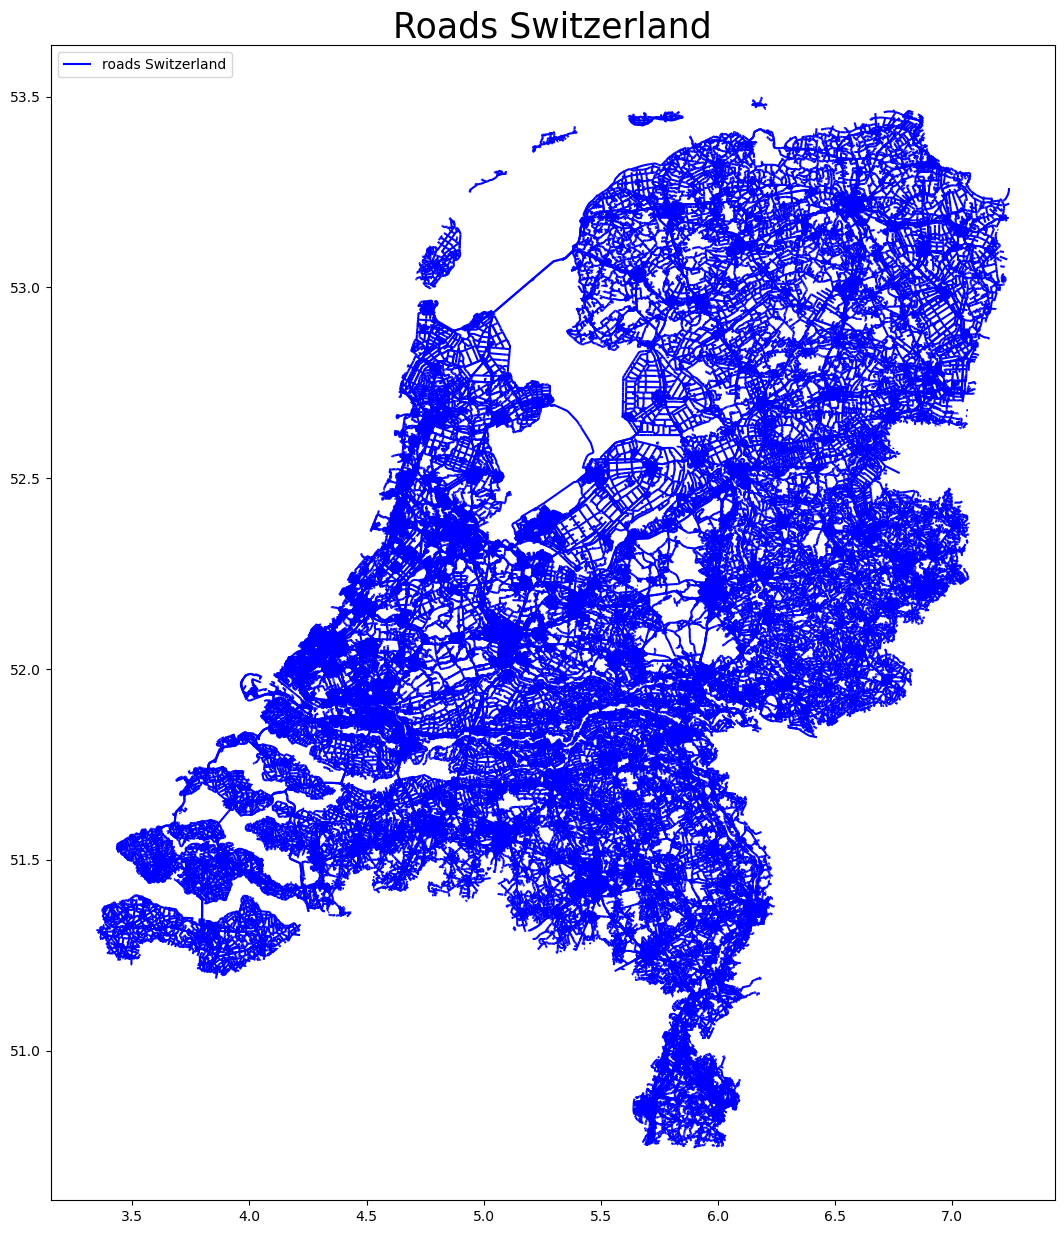

In [13]:
# plot results
ax = gdf_roads.plot(
    figsize=(15, 15),
    alpha=1,
    markersize=5,
    color="blue",
    edgecolor="blue",
    label="roads Switzerland",
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc="upper left")
ax.set_title("Roads Switzerland", fontsize=25)
plt.show()

**Extracting any custom-made query from the data dump**

Any other tags that are available on openstreetmap can also be queried with the `extract()` method.
Two variables have to be specified: `osm_keys`, a list with all the columns to report in the gdf, and `osm_query`, a string of key-value constraints to apply during the search.

In [14]:
# Forests (multipolygons) in Switzerland
osm_keys = ["landuse"]
osm_query = "landuse='forest'"
gdf_forest = osm_flex.extract.extract(
    path_ctr_dump, "multipolygons", osm_keys, osm_query
)

INFO:osm_flex.extract:query is finished, lets start the loop
extract multipolygons: 100%|██████████| 533232/533232 [01:45<00:00, 5050.98it/s] 


In [15]:
# set crs
gdf_forest = gdf_forest.to_crs(epsg=4326)

/var/folders/y5/t1z41tgj7dv50sm2_29dn8740000gp/T/ipykernel_72400/3442191121.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


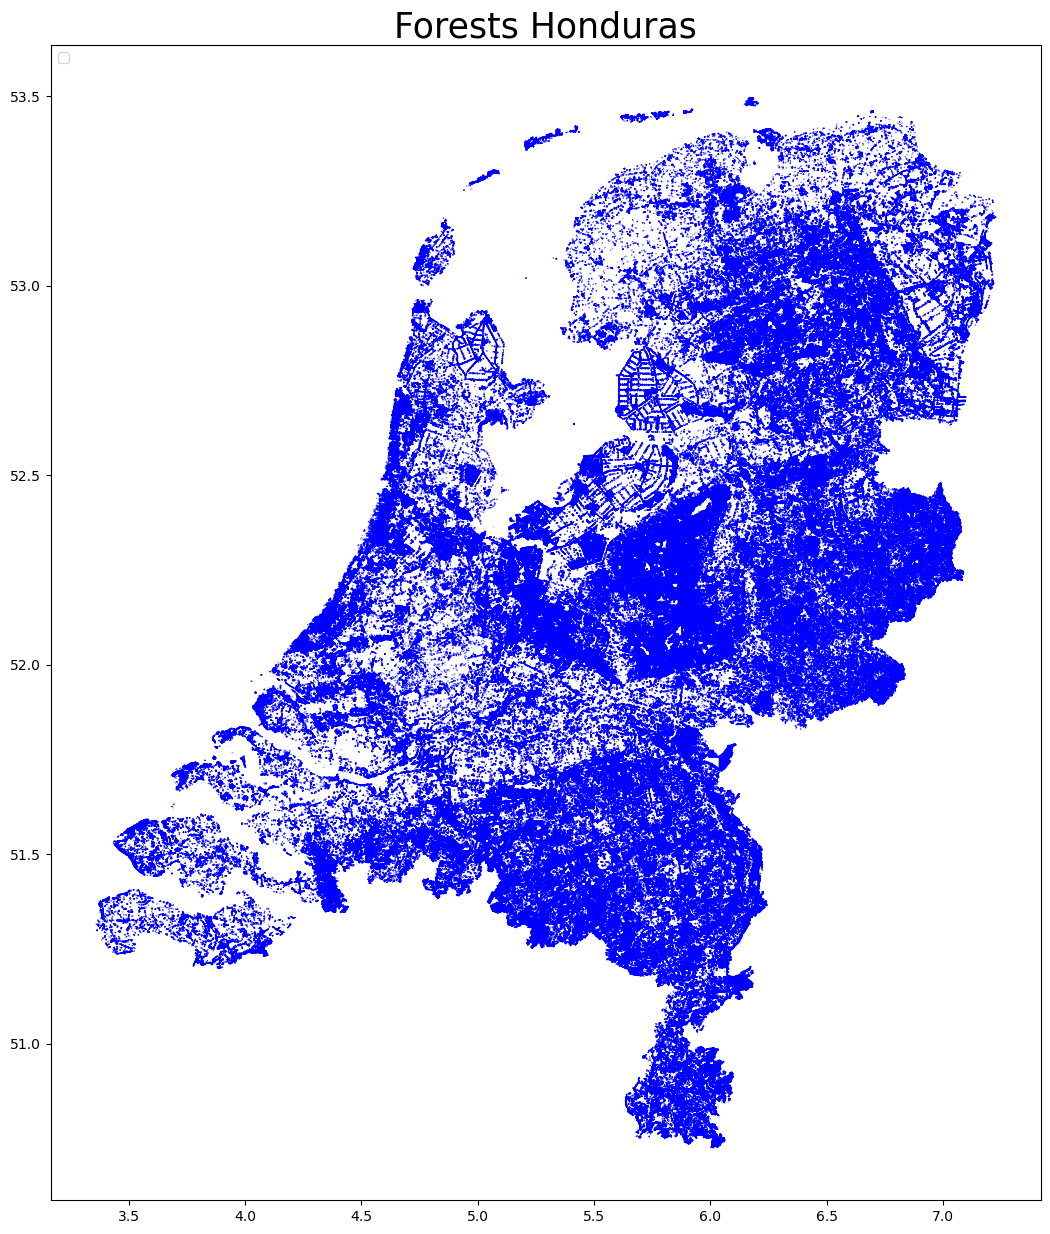

In [16]:
# Plot results
ax = gdf_forest.plot(
    figsize=(15, 15),
    alpha=1,
    markersize=5,
    color="blue",
    edgecolor="blue",
    label="forests HND",
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc="upper left")
ax.set_title("Forests Honduras", fontsize=25)
plt.show()

## How to compute impacts using polygons or lines as exposure in CLIMADA
Here we provide a brief example of an impact calculation using OSM data retrieved 
using `osm-flex`. For this we use the `calc_geom_impact` from the util module `lines_polys_handler`. 
The calculation of impacts using lines or polygons exposures consists in the following steps:
1. Disaggregation of line and polygon data into point exposure:
    * Interpolate geometries to points to fit in an `Exposure` instance; 
    * Disaggregate the respective geometry values to the point values
2. Perform the impact calculation in CLIMADA with the point exposure
3. Aggregate the calculated point `Impact` back to an impact instance for the initial polygons or lines  

Please refer to the [documentation](https://climada-python.readthedocs.io/en/latest/tutorial/climada_entity_Exposures_polygons_lines.html) for more details on how to use lines and polygons as exposures within CLIMADA.


### Impact calculation example: roads and forests in the Netherlands
For our example, we will compute the damages from winter storms on some roads and
forests in the Netherlands. First, we define our hazard (winter storms), impact function,
and exposures (road and forests retrieved from OpenStreetMap).


In [96]:
from climada.util.api_client import Client
from climada.hazard import TropCyclone
import climada.util.lines_polys_handler as u_lp
from climada.entity.impact_funcs import ImpactFuncSet
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope

from climada.entity import Exposures


HAZ = Client().get_hazard("storm_europe", name="test_haz_WS_nl", status="test_dataset")

EXP_POLY = Exposures(gdf_forest)

EXP_LINE = Exposures(gdf_roads)

EXP_MIX = Exposures.concat([EXP_POLY, EXP_LINE])

IMPF_POLY = ImpfStormEurope.from_welker()

IMPF_SET = ImpactFuncSet([IMPF_POLY])

EXP_LINE.data["impf_WS"] = 1  # specify impact function

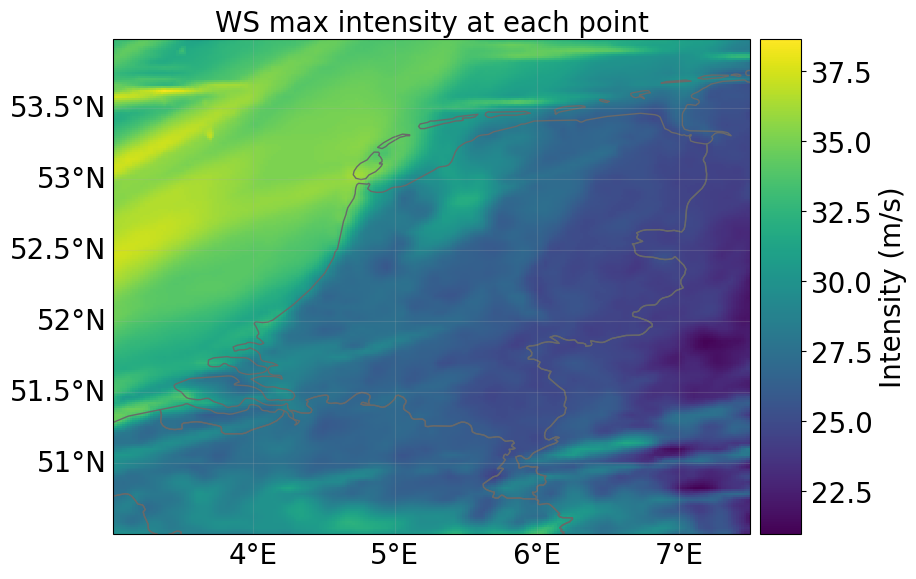

In [95]:
# plot hazard, impact function
HAZ.plot_intensity(0);

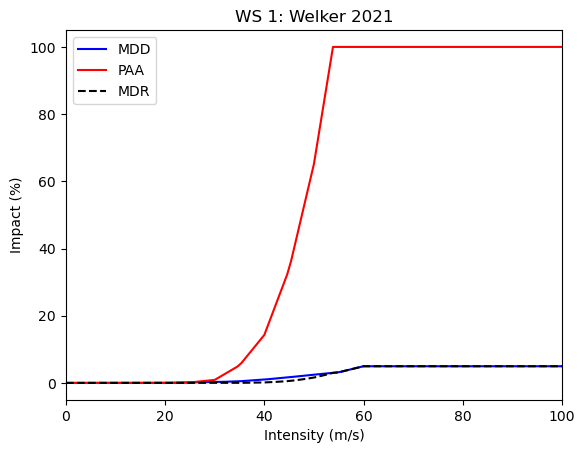

In [90]:
IMPF_SET.plot();

Next, we crop our exposure to a single province, here Northern-Holland.

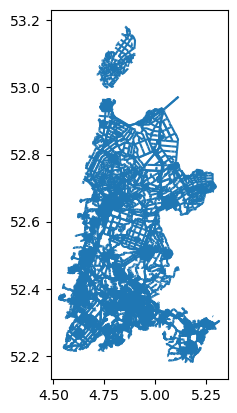

In [97]:
# crop exposure to a single province to make calculation less expensive
def select_province(gdf):
    from cartopy.io import shapereader
    from climada_petals.entity.exposures.black_marble import country_iso_geom

    # open the file containing the Netherlands admin-1 polygons
    shp_file = shapereader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )
    shp_file = shapereader.Reader(shp_file)

    # extract the NL polygons for "Noord-Holland"
    prov_names = {"Netherlands": ["Noord-Holland"]}  # "Noord-Holland"

    polygon_Netherlands, polygons_prov_NL = country_iso_geom(prov_names, shp_file)

    # gdf = gdf[gdf.is_valid] #discard unvalid geometries
    gdf = gdf[gdf.within(polygons_prov_NL["NLD"][0])]  # select admin-1 polygon

    return gdf


EXP_LINE.data = select_province(EXP_LINE.data)
EXP_LINE.plot()

Finally, we use the wrapper function `calc_geom_impact` to compute the impacts in one line of code.
For a reminder, the `calc_geom_impact` is covering the 3 steps of shapes-to-points disagreggation,
impact calculation, and reaggregation to the original shapes.

In [98]:
# disaggregate in the same CRS as the exposures are defined (here meters), resolution 500m
# divide values on points
# aggregate by summing

impact = u_lp.calc_geom_impact(
    exp=EXP_LINE,
    impf_set=IMPF_SET,
    haz=HAZ,
    res=500,
    to_meters=True,
    disagg_met=u_lp.DisaggMethod.FIX,
    disagg_val=1e5,
    agg_met=u_lp.AggMethod.SUM,
);

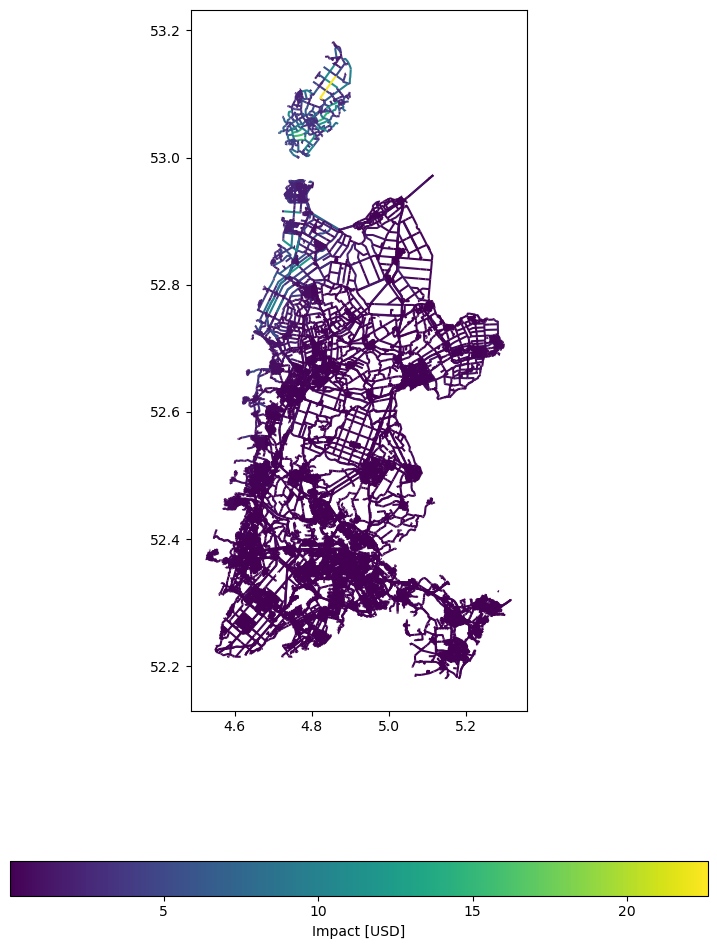

In [99]:
# plot the calculated impacts
u_lp.plot_eai_exp_geom(impact);

For more details explanations on the calculations of impacts using lines and polygons and on
the disaggregation-reaggregation process, please refer to the [tutorial](https://climada-python.readthedocs.io/en/latest/tutorial/climada_entity_Exposures_polygons_lines.html).